#  **POV (Proof of Value) Bike Sharing Datase**




In [ ]:
import os
import glob
import pandas as pd

chemin = "data"
fichiers = sorted(glob.glob(os.path.join(chemin, "*.csv")))

print("Nombre de fichiers :", len(fichiers))


Nombre de fichiers : 24


In [40]:
def charger_un_fichier(chemin_fichier):
    # Je charge le fichier mensuel en forçant started_at et ended_at en string pour éviter les soucis de parsing
    df_parmois = pd.read_csv(
        chemin_fichier,
        dtype={"started_at": "string", "ended_at": "string"},
        low_memory=False
    )

    # Je convertis ensuite en datetime et errors="coerce" permet d'éviter que le code casse si une date est mal formée
    df_parmois["started_at"] = pd.to_datetime(df_parmois["started_at"], errors="coerce")
    df_parmois["ended_at"]   = pd.to_datetime(df_parmois["ended_at"], errors="coerce")

    return df_parmois


# Je regroupe tous les mois en un seul DataFrame
df = pd.concat([charger_un_fichier(f) for f in fichiers], ignore_index=True)

# Petit contrôle rapide pour vérifier que tout est cohérent
print("Shape brute :", df.shape)
print("Date min :", df["started_at"].min())
print("Date max :", df["started_at"].max())


Shape brute : (12776970, 13)
Date min : 2024-01-01 00:00:15
Date max : 2025-12-31 23:53:41.718000


In [41]:
# Ici je crée une colonne durée afin de supprimer les trajets incoherents (<30s et >24h).

df["duree_sec"] = (
    df["ended_at"] - df["started_at"]
).dt.total_seconds()

print(df["duree_sec"].describe())

print("Doublons ride_id :", df["ride_id"].duplicated().sum())
print("Durées <= 0 :", (df["duree_sec"] <= 0).sum())
print("Durées > 24h :", (df["duree_sec"] > 24*3600).sum())


count    1.277697e+07
mean     7.035891e+02
std      4.260980e+05
min     -7.615222e+08
25%      3.259190e+02
50%      5.686310e+02
75%      9.781410e+02
max      9.359729e+04
Name: duree_sec, dtype: float64
Doublons ride_id : 141
Durées <= 0 : 1136
Durées > 24h : 9701


In [42]:
#Ici je suprimme les doublons car ride_id est unique, les valeurs manquantes ainsi que les trajets incoherents

taille = len(df)

df = df.dropna(subset=["started_at", "ended_at"])
df = df.drop_duplicates(subset=["ride_id"])
df = df[
    (df["duree_sec"] > 0) &
    (df["duree_sec"] < 24*3600)
]

print("Lignes supprimées :", taille - len(df))
print("Shape après cleaning :", df.shape)


Lignes supprimées : 10963
Shape après cleaning : (12766007, 14)


In [43]:
#Je cree une colonne heure afin d'avoir par la suite une colonne avec le nombre de trajets par heure dans un nouveau dataframe

df["heure"] = df["started_at"].dt.floor("h")

df_horaire = (
    df.groupby("heure")
    .size()
    .rename("nb_trajets")
    .reset_index()
    .sort_values("heure")
)

print("Min/Max :", df_horaire["heure"].min(), df_horaire["heure"].max())


Min/Max : 2024-01-01 00:00:00 2025-12-31 23:00:00


In [44]:
# Je crée une plage horaire complète entre la première et la dernière date
# L'idée est d'avoir une série continue, sans trous horaires
plage_complete = pd.date_range(
    start=df_horaire["heure"].min(),
    end=df_horaire["heure"].max(),
    freq="h",
)

# Si une heure n'existe pas dans les données, elle sera ajoutée avec NaN
df_horaire = df_horaire.set_index("heure").reindex(plage_complete)

# Je renomme l'index pour garder quelque chose de propre
df_horaire.index.name = "heure"
df_horaire = df_horaire.reset_index()

# Les heures ajoutées artificiellement qui ont des NaN sont remplacé par 0
df_horaire["nb_trajets"] = df_horaire["nb_trajets"].fillna(0).astype(int)

print("Shape horaire continue :", df_horaire.shape)


Shape horaire continue : (17544, 2)


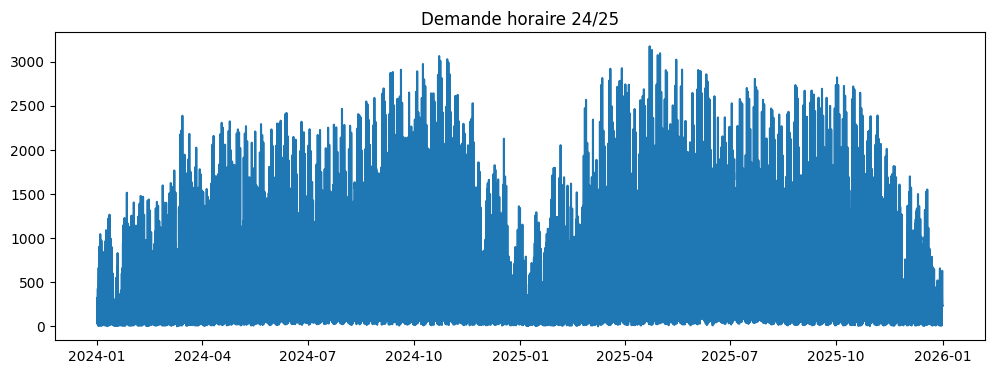

In [45]:
import matplotlib.pyplot as plt

# Petit plot pour vérifier visuellement que la série est cohérente
# Ça permet de voir les saisons et les pics principaux

plt.figure(figsize=(12,4))
plt.plot(df_horaire["heure"], df_horaire["nb_trajets"])
plt.title("Demande horaire 24/25")
plt.show()


In [46]:
# Je crée des variables calendaires simples afin de de capter la structure

df_horaire["heure_du_jour"] = df_horaire["heure"].dt.hour
df_horaire["jour_semaine"]  = df_horaire["heure"].dt.dayofweek
df_horaire["mois"]          = df_horaire["heure"].dt.month
df_horaire["est_weekend"]   = df_horaire["jour_semaine"].isin([5,6]).astype(int)

df_horaire["lag_24"]  = df_horaire["nb_trajets"].shift(24)
df_horaire["lag_168"] = df_horaire["nb_trajets"].shift(168)

df_modele = df_horaire.dropna().copy()


In [47]:
# Split strict dans le temps pour éviter toute fuite d'information

train = df_modele[df_modele["heure"] < "2025-10-01"].copy()
val   = df_modele[(df_modele["heure"] >= "2025-10-01") & (df_modele["heure"] < "2025-11-01")].copy()
test  = df_modele[df_modele["heure"] >= "2025-11-01"].copy()

print("Train :", train.shape)
print("Val   :", val.shape)
print("Test  :", test.shape)


Train : (15168, 8)
Val   : (744, 8)
Test  : (1464, 8)


In [48]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# sMAPE pour mesurer l'erreur relative

def smape(y_true, y_pred):
    return np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    ) * 100

# Baseline simple : même heure que la semaine précédente

mae_baseline = mean_absolute_error(test["nb_trajets"], test["lag_168"])
smape_baseline = smape(test["nb_trajets"], test["lag_168"])

print("Baseline MAE :", round(mae_baseline, 2))
print("Baseline sMAPE :", round(smape_baseline, 2), "%")


Baseline MAE : 151.06
Baseline sMAPE : 34.32 %


In [49]:
from sklearn.ensemble import RandomForestRegressor
# Features utilisées par le modèle
features = ["heure_du_jour", "jour_semaine", "mois", "est_weekend", "lag_24", "lag_168"]

X_train = train[features]
y_train = train["nb_trajets"]

X_val = val[features]
y_val = val["nb_trajets"]

X_test = test[features]
y_test = test["nb_trajets"]

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

val_pred = model.predict(X_val)
test_pred = model.predict(X_test)


In [50]:
# Performance validation
mae_val = mean_absolute_error(y_val, val_pred)
smape_val = smape(y_val, val_pred)

# Performance finale sur test
mae_test = mean_absolute_error(y_test, test_pred)
smape_test = smape(y_test, test_pred)

print("VAL  MAE :", round(mae_val, 2), "| sMAPE :", round(smape_val, 2), "%")
print("TEST MAE :", round(mae_test, 2), "| sMAPE :", round(smape_test, 2), "%")


VAL  MAE : 105.65 | sMAPE : 16.79 %
TEST MAE : 115.84 | sMAPE : 28.83 %


In [51]:
# MASE pour comparer proprement au modèle naïf
mase_test = mae_test / mae_baseline

tableau_resultats = pd.DataFrame({
    "Modèle": ["Baseline (lag_168)", "RandomForest"],
    "MAE_test": [mae_baseline, mae_test],
    "sMAPE_test_%": [smape_baseline, smape_test],
    "MASE": [1.0, mase_test]
})

tableau_resultats


,Modèle,MAE_test,sMAPE_test_%,MASE
0,Baseline (lag_168),151.062158,34.322444,1.000000
1,RandomForest,115.839075,28.833280,0.766831


In [52]:
# Je regarde les erreurs en valeur absolue
test_results = test.copy()
test_results["prediction"] = test_pred
test_results["abs_erreur"] = abs(test_results["prediction"] - test_results["nb_trajets"])

# Indicateur simple : % d'heures où l'erreur dépasse 300 trajets
seuil = 300
pct_heures_sup_300 = (test_results["abs_erreur"] > seuil).mean() * 100

print("% heures avec erreur >", seuil, ":", round(pct_heures_sup_300, 2), "%")


% heures avec erreur > 300 : 9.56 %


In [53]:
# Je regarde spécifiquement Thanksgiving et Noël
jours_feries = ["2025-11-27", "2025-12-25"]
jours_feries_dates = set(pd.to_datetime(jours_feries).date)

test_feries = test_results[test_results["heure"].dt.date.isin(jours_feries_dates)]
mae_feries = test_feries["abs_erreur"].mean()

print("MAE jours fériés :", round(mae_feries, 2))


MAE jours fériés : 336.02
